In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.ar_model import AutoReg
import os

import mock_trading_utils
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(0)

In [8]:
# Define metric calculation functions
def sharpe_ratio(returns, risk_free_rate=0.0):
    return annual_returns(returns) / annualized_volatility(returns)

def max_drawdown(returns, rebalance='daily', interval=2):
    if rebalance=='daily':
        cumulative_returns = 1 + returns.cumsum()
    else:
        cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min() 

def annual_returns(returns, periods_per_year=252, rebalance='daily'):
    if rebalance=='daily':
        return returns.sum() * periods_per_year/returns.count()
    else:
        return np.prod(1 + returns)**(periods_per_year / returns.count()) - 1

def annualized_volatility(returns, periods_per_year=252):
    return np.std(returns) * np.sqrt(periods_per_year)  # to normalize the trading window to one day

In [9]:
def get_metrics(model, market, interval, pos_dir, df, show_metrics: bool=False, market_neutral: bool=False, sample_n=None, cost_ratio=0.):
    index = df.index.name
    prediction_dates = df[df.index > '2023'].index

    missing = df[df.index > '2023'].iloc[0].isna()
    df = df[df.columns[~missing]]
    df_back = df.bfill().dropna(how='any', axis=1) # we execute at a future price if the current price is not available

    returns = df_back.diff(interval-1).shift(-(interval-1)) / df_back
    returns = returns[returns.index > '2023']
    if model == 'random':
        nan_size = returns.isna().sum().sum()
        total_size = returns.size
        zero_size = (returns == 0).sum().sum()
        non_nan_size = total_size - nan_size - zero_size
        pos = np.random.uniform(size=returns.shape)
        up_ratio = (returns > 0).sum().sum() / non_nan_size
        pos = np.where(pos < up_ratio, 1, -1)
        pos = pd.DataFrame(pos, index=returns.index, columns=returns.columns)
    elif model == 'ar1':
        pos = pd.DataFrame(index=returns.index, columns=returns.columns)
        prediction_dates = pos.index
        in_df = df[df.index < prediction_dates[0]].ffill().dropna(axis=1, how='any')
        tickers = in_df.columns
        for ticker in tickers:
            ts = in_df[ticker][-512:].to_numpy()
            model_fit = AutoReg(ts, lags=1).fit()
            forecast = model_fit.predict(start=len(ts), end=len(ts)+len(pos)+interval-1)
            for i, date in enumerate(prediction_dates):
                pos.at[date, ticker] = 1 if forecast[i+interval-1] > forecast[i] else -1
    else:
        pos_file = os.path.join(pos_dir, model, f'{market}_{interval}_positions.csv')
        pos = pd.read_csv(pos_file).set_index(index)
    returns.index = pd.to_datetime(returns.index)
    pos.index = pd.to_datetime(pos.index)
    pos = pos.loc[returns.index]
    pos = pos.fillna(0)
    if returns.shape[1] < pos.shape[1]:
        pos = pos[returns.columns]
    if market_neutral:
        pos = pos.sub(pos.mean(axis=1), axis=0) 
    pos  = pos.div(pos.abs().sum(axis=1), axis=0) / (interval-1) #normalize the L1-norm
    trading_cost = pos.abs().sum(axis=1) * cost_ratio
    total_trades = pos.abs().sum().sum()
    pnl = pos * returns
    if sample_n is not None:
        pnl = pnl.sample(sample_n, axis=1)
    indiv_pnl = pnl
    pnl = pnl.sum(axis=1)
    pnl -= trading_cost
    pnl = pnl.shift(interval - 1)
    neutral_cost = pnl.sum() / total_trades * 100 / 2 # divide by 2 to account for buy/sell actions

    # Calculate metrics
    sharpe = sharpe_ratio(pnl, risk_free_rate=0.0)
    mdd = max_drawdown(pnl)
    ann_ret = annual_returns(pnl)
    ann_vol = annualized_volatility(pnl)

    if show_metrics:

        # Plot PnL over time
        plt.figure(figsize=(7, 4))
        pnl_cumsum = pnl.cumsum()
        plt.plot(pnl_cumsum, label='PnL Cumulative Sum')
        plt.title('PnL Over Time')
        plt.xlabel('Date')
        plt.ylabel('PnL')
        plt.legend()
        plt.grid(True)

        # Set major locator to show date labels less frequently
        locator = mdates.MonthLocator(interval=1000)
        plt.gca().xaxis.set_major_locator(locator)

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Print calculated metrics
        print(f"Sharpe Ratio: {sharpe}")
        print(f"Maximum Drawdown: {mdd}")
        print(f"Annualized Return: {ann_ret}")
        print(f"Annualized Volatility: {ann_vol}")

    return pnl, neutral_cost, indiv_pnl

In [80]:
asset = 'crypto_daily'
df = mock_trading_utils.load_data_returns(asset=asset)

<Figure size 1000x700 with 0 Axes>

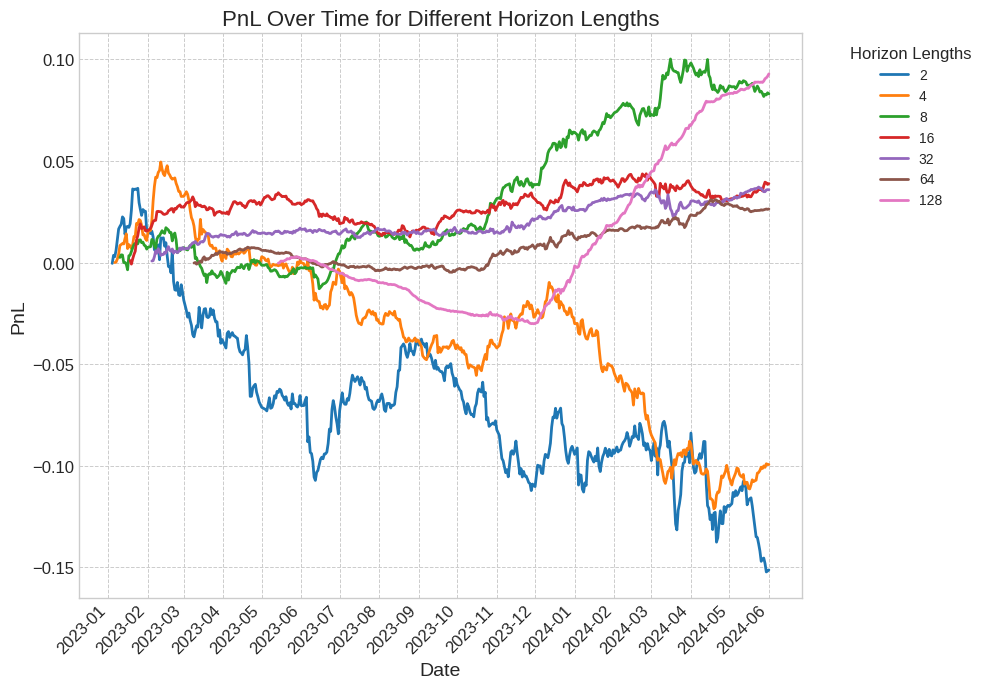

,Ann Sharpe,Max Drawdown,Ann Returns,Ann Volatility,Neutral Cost(%),Accuracy
Horizon,,,,,,
2,-0.745512,-0.182126,-0.076358,0.102424,-0.015120,0.492655
4,-0.591077,-0.162648,-0.050382,0.085237,-0.029809,0.495718
8,0.518868,-0.029537,0.042459,0.081830,0.058145,0.500427
16,0.262015,-0.021025,0.020225,0.077190,0.058387,0.501610
32,0.240407,-0.012684,0.019279,0.080195,0.111231,0.501330
64,0.176526,-0.012266,0.015240,0.086335,0.166502,0.499329
128,0.456442,-0.032881,0.062766,0.137512,1.179885,0.508564


In [81]:
intervals = [2, 4, 8, 16, 32, 64, 128]
# intervals = [128]
pnls = []
neutral_costs = []
accuracies = []

for interval in intervals:
    pnl, neutral_cost, indiv_pnl = get_metrics(market=asset, interval=interval, model='random', \
             pos_dir=os.path.abspath(os.path.join(os.getcwd(), os.path.pardir, 'mock_trading')), df=df, market_neutral=False)
    accuracy = indiv_pnl.gt(0).sum().sum() / indiv_pnl.count().sum()
    pnls.append(pnl)
    neutral_costs.append(neutral_cost)
    accuracies.append(accuracy)
pnls = pd.DataFrame(pnls).T
pnls.columns = intervals

sharpes = pnls.apply(sharpe_ratio, axis=0) / np.sqrt(intervals)
mdds = pnls.apply(max_drawdown, axis=0)
ann_ret = pnls.apply(annual_returns, axis=0)
ann_vol = pnls.apply(annualized_volatility, axis=0) * np.sqrt(intervals)
metrics_df = pd.DataFrame({'Ann Sharpe': sharpes, 'Max Drawdown': mdds, 'Ann Returns': ann_ret, 'Ann Volatility': ann_vol, 'Neutral Cost(%)': neutral_costs,\
    'Accuracy': accuracies})
metrics_df.index = intervals
metrics_df.index.name = 'Horizon'

# Plotting all PnLs on the same graph
plt.figure(figsize=(10, 7))
ax = pnls.cumsum().plot(linewidth=2.0, figsize=(10, 7))
plt.title('PnL Over Time for Different Horizon Lengths', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('PnL', fontsize=14)
# Legend
plt.legend(title='Horizon Lengths', fontsize=10, title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

# Grid
plt.grid(True, linestyle='--', linewidth=0.7)

# X-axis formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, fontsize=12)

# Y-axis formatting
plt.yticks(fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

metrics_df

In [ ]:
# intervals = [2, 4, 8, 16, 32, 64, 128]
intervals = [128]
pnls = []
neutral_costs = []
accuracies = []
pnls = {}

for model in ['original', 'random', 'ar1', 'fine-tuned']:
    for interval in intervals:
        pnl, neutral_cost, indiv_pnl = get_metrics(market=asset, interval=interval, model=model, \
                pos_dir=os.path.abspath(os.path.join(os.getcwd(), os.path.pardir, 'mock_trading')), df=df, market_neutral=True)
        pnls[model] = pnl

/tmp/ipykernel_187032/4229893300.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pos = pos.fillna(0)


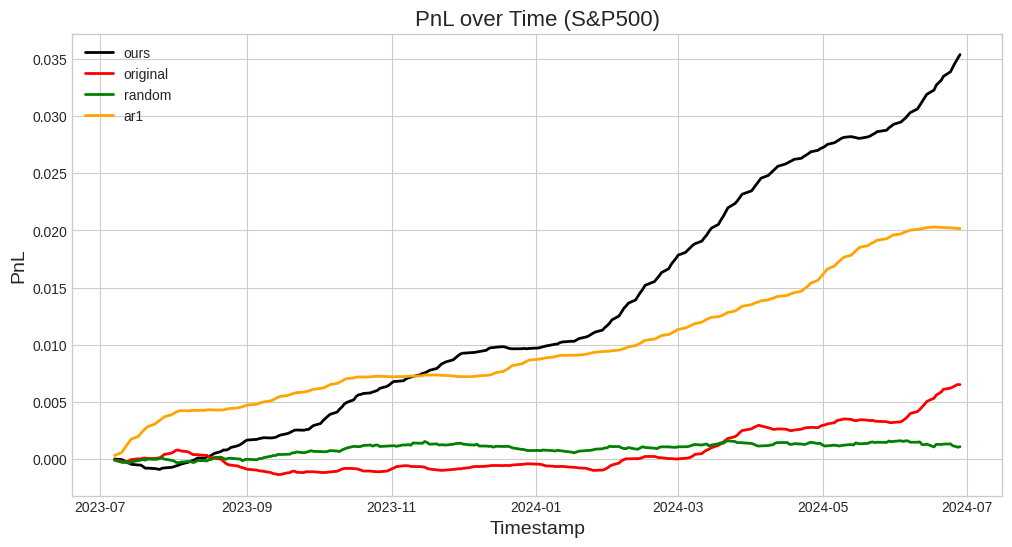

In [8]:
plt.figure(figsize=(12, 6))

plt.plot(pnls['fine-tuned'].cumsum(), label='ours', color='black', linewidth=2.0)
plt.plot(pnls['original'].cumsum(), label='original', color='red', linewidth=2.0)
plt.plot(pnls['random'].cumsum(), label='random', color='green', linewidth=2.0)
plt.plot(pnls['ar1'].cumsum(), label='ar1', color='orange', linewidth=2.0)

plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('PnL', fontsize=14)
plt.title('PnL over Time (S&P500)', fontsize=16)
plt.legend(loc='best')
plt.grid(True)
plt.show()